Ex. 1
1. In the first exercise you will generate a 3D dataset with 500 points using
np.random.multivariate normal function with the mean vector [5, 10,
2] and the covariance matrix [[3, 2, 2], [2, 10, 1], [2, 1, 2]] and plot it
(3D). Then you will perform the PCA steps from the course (center data,
compute covariance matrix, EVD).

(500, 3)


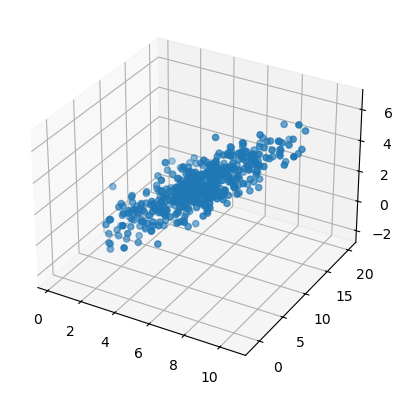

In [1]:
import numpy as np 
import matplotlib.pyplot as plt

X = np.random.multivariate_normal(mean=[5, 10, 2], cov=[[3, 2, 2], [2, 10, 1], [2, 1, 2]], size=500)
print(X.shape)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(*X.T,)
plt.show()

In [2]:
# PCA STEPS
# 1. Center data
Z = X - np.mean(X, axis=0) 

# 2. Covariance matrix calculation
cov_matrix = Z.T @ Z
cov_matrix = cov_matrix / Z.shape[0]

# 3. EVD
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)


2. Plot in the same figure both the cumulative explained variance (computed with the sorted [descending] eigenvalues and the numpy.cumsum
function) with the pyplot.step function and the individual variances (respecting the order) - using the pyplot.bar function.

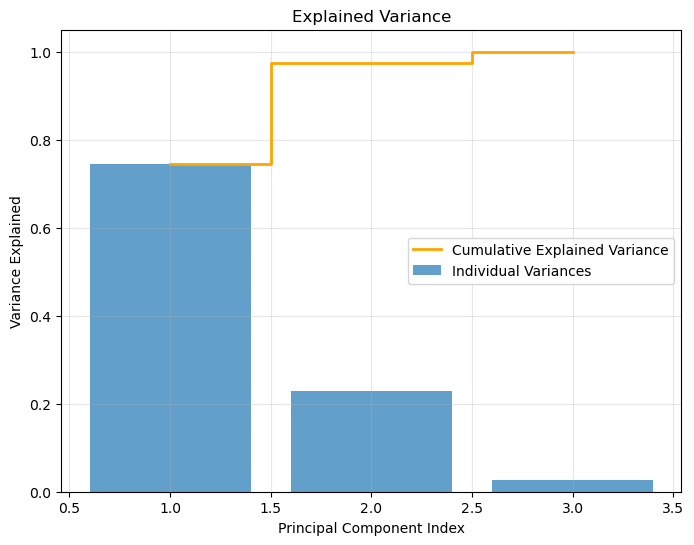

In [10]:
eigenvalues_sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues_sorted = eigenvalues[eigenvalues_sorted_indices]
eigenvectors_sorted = eigenvectors[:, eigenvalues_sorted_indices]

individual_variances = eigenvalues_sorted / np.sum(eigenvalues_sorted)
cumulative_explained_variance = np.cumsum(individual_variances)

plt.figure(figsize=(8, 6))
plt.bar(range(1, len(individual_variances) + 1), individual_variances, label="Individual Variances", alpha=0.7)
plt.step(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, where='mid', label="Cumulative Explained Variance", color='orange', linewidth=2)

plt.xlabel('Principal Component Index')
plt.ylabel('Variance Explained')
plt.title('Explained Variance')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

3. Project the data in the new space and identify the outliers based on the deviation of the values over the dimension corresponding to the 3rd principal component (compared to the mean of all the values of the same component). Use 0.1 as contamination rate and the numpy.quantile function
in order to find the corresponding threshold and predict the labels. Plot the dataset again (using a different color for points labeled as anomalies). Repeat the same steps for the second principal component.

(500, 3)


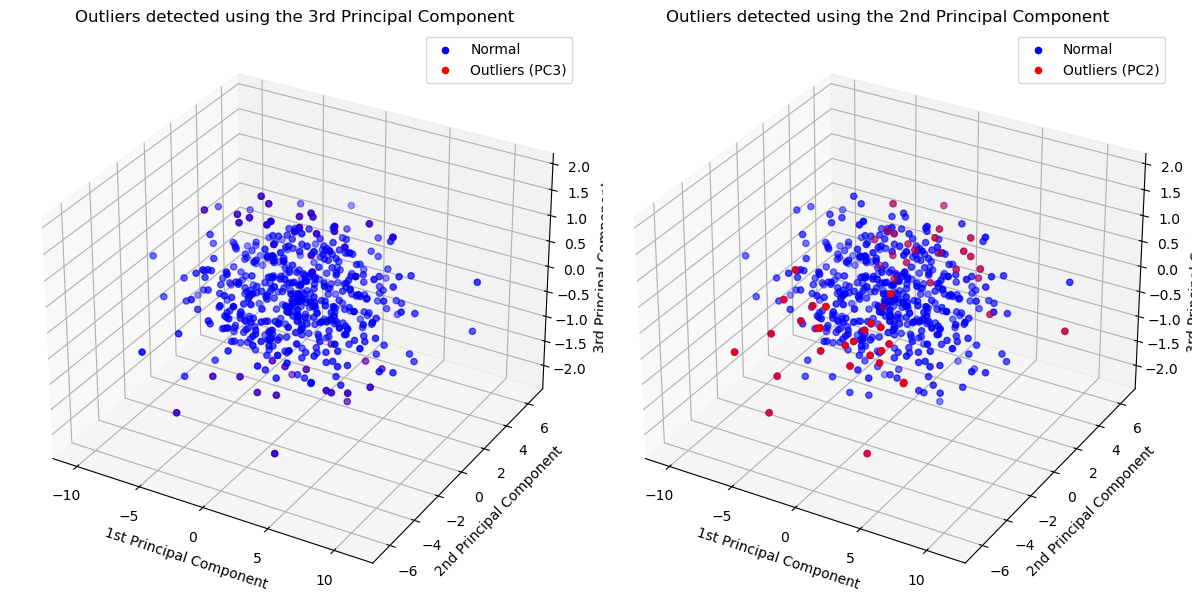

In [ ]:
X_pca = Z @ eigenvectors_sorted
print(X_pca.shape)
def detect_outliers(component_data, contamination_rate):
    mean_value = np.mean(component_data)
    deviations = np.abs(component_data - mean_value)
    threshold = np.quantile(deviations, 1 - contamination_rate)
    outliers = deviations > threshold
    return outliers, threshold

outliers_pc3, threshold_pc3 = detect_outliers(X_pca[:, 2], contamination_rate=0.1)
outliers_pc2, threshold_pc2 = detect_outliers(X_pca[:, 1], contamination_rate=0.1)

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c="blue", label="Normal")
ax.scatter(
    X_pca[outliers_pc3, 0], X_pca[outliers_pc3, 1], X_pca[outliers_pc3, 2], c="red", label="Outliers (PC3)"
)
ax.set_title("Outliers detected using the 3rd Principal Component")
ax.set_xlabel("1st Principal Component")
ax.set_ylabel("2nd Principal Component")
ax.set_zlabel("3rd Principal Component")
ax.legend()

ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c="blue", label="Normal")
ax2.scatter(
    X_pca[outliers_pc2, 0], X_pca[outliers_pc2, 1], X_pca[outliers_pc2, 2], c="red", label="Outliers (PC2)"
)
ax2.set_title("Outliers detected using the 2nd Principal Component")
ax2.set_xlabel("1st Principal Component")
ax2.set_ylabel("2nd Principal Component")
ax2.set_zlabel("3rd Principal Component")
ax2.legend()

plt.tight_layout()
plt.show()



4. Project the data in the new space and identify the outliers based on the normalized distance (by the corresponding standard deviation) of the data
points to the centroid (in the new space) along all the principal components (follow the steps from the algorithm in the first part of the lab). Plot the dataset again (using a different color for points labeled as anomalies)

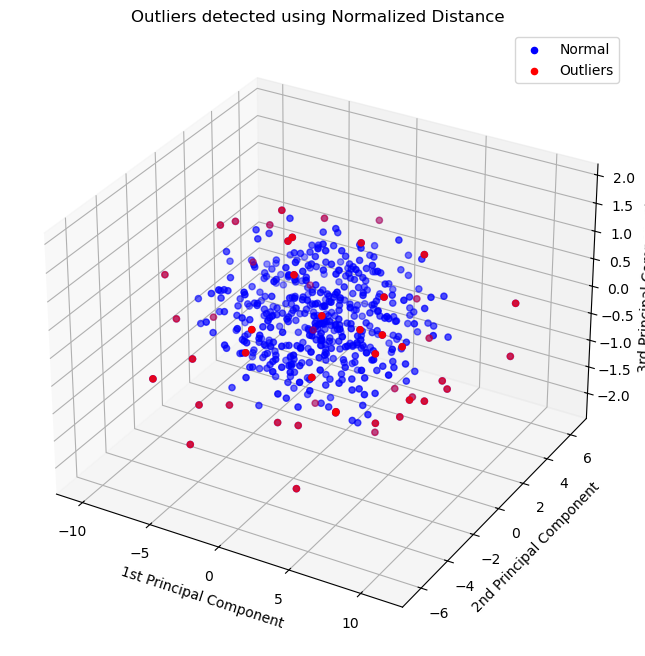

In [19]:
eigenvalues_sqrt_inv = 1 / np.sqrt(eigenvalues_sorted)
X_pca_normalized = X_pca * eigenvalues_sqrt_inv

centroid = np.mean(X_pca_normalized, axis=0)
anomaly_scores = np.sum((X_pca_normalized - centroid) ** 2, axis=1)

contamination_rate = 0.1
threshold = np.quantile(anomaly_scores, 1 - contamination_rate)
outliers = anomaly_scores > threshold

fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c="blue", label="Normal")
ax.scatter(
    X_pca[outliers, 0], X_pca[outliers, 1], X_pca[outliers, 2], c="red", label="Outliers"
)
ax.set_title("Outliers detected using Normalized Distance")
ax.set_xlabel("1st Principal Component")
ax.set_ylabel("2nd Principal Component")
ax.set_zlabel("3rd Principal Component")
ax.legend()
plt.show()

Ex. 2
1. In this exercise you will use the shuttle dataset. Split the data in a training set and a testing set (60% of data). Standardize your data and fit a pyod.models.pca.PCA model with the training set using the real contamination rate of the training set. Plot the cumulative explained variance
and the individual variances as in the previous exercise (you can access the variances with the explained variance attribute).

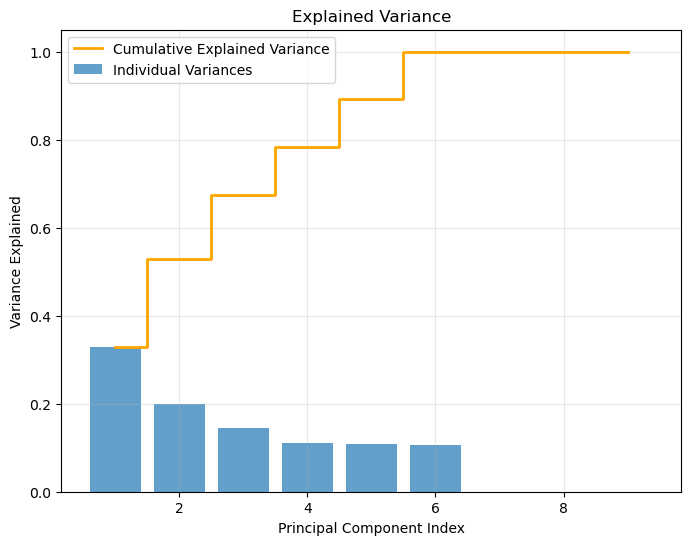

In [23]:
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from pyod.models.pca import PCA


data = loadmat('shuttle.mat')
X = data['X'] 
y = data['y'].ravel()  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

contamination_rate = np.sum(y_train) / len(y_train)
pca = PCA(contamination=contamination_rate)
pca.fit(X_train)

individual_variances = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(individual_variances)

plt.figure(figsize=(8, 6))
plt.bar(range(1, len(individual_variances) + 1), individual_variances, label="Individual Variances", alpha=0.7)
plt.step(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, where='mid', label="Cumulative Explained Variance", color='orange', linewidth=2)

plt.xlabel('Principal Component Index')
plt.ylabel('Variance Explained')
plt.title('Explained Variance')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


2. Compute the balanced accuracy for both the train and test sets. Then fit the pyod.models.kpca.KPCA model with the same training data and compute the scores again.

In [24]:
from sklearn.metrics import balanced_accuracy_score
from pyod.models.kpca import KPCA

y_train_pred_pca = pca.predict(X_train)
y_test_pred_pca = pca.predict(X_test)
train_balanced_acc_pca = balanced_accuracy_score(y_train, y_train_pred_pca)
test_balanced_acc_pca = balanced_accuracy_score(y_test, y_test_pred_pca)

print(f"PCA Balanced Accuracy - Train: {train_balanced_acc_pca:.4f}, Test: {test_balanced_acc_pca:.4f}")

kpca = KPCA(contamination=contamination_rate, kernel='rbf')
kpca.fit(X_train)

y_train_pred_kpca = kpca.predict(X_train)
y_test_pred_kpca = kpca.predict(X_test)
train_balanced_acc_kpca = balanced_accuracy_score(y_train, y_train_pred_kpca)
test_balanced_acc_kpca = balanced_accuracy_score(y_test, y_test_pred_kpca)

print(f"KPCA Balanced Accuracy - Train: {train_balanced_acc_kpca:.4f}, Test: {test_balanced_acc_kpca:.4f}")

PCA Balanced Accuracy - Train: 0.9719, Test: 0.9752
KPCA Balanced Accuracy - Train: 0.6268, Test: 0.7478


Ex. 3
1. In this exercise you will use the shuttle dataset from ODDS. Load the data using scipy.io.loadmat() and use train test split() to split it into train and test subsets (use 50% of data for testing). Use min-max normalization to bring your train data in the [0-1] range.

In [77]:
from sklearn.preprocessing import MinMaxScaler

data = loadmat('shuttle.mat')
X = data['X']
y = data['y'].ravel()  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


2. Design an Autoencoder class that subclasses keras.Model. Use the keras.Sequential model to create encoder and decoder submodels that
contain only keras.layers.Dense layers. The 2 submodels should contain layers with [8, 5, 3] and [5, 8, 9] output units. Use relu activation
function for each layer except the last one (from the decoder), which will use sigmoid activation.

In [78]:
import keras

class Autoencoder(keras.Model):
    def __init__(self):
        super().__init__()
        
        self.encoder = keras.Sequential([
            keras.layers.Dense(8, activation='relu'),
            keras.layers.Dense(5, activation='relu'),
            keras.layers.Dense(3, activation='relu')
        ])
        self.decoder = keras.Sequential([
            keras.layers.Dense(5, activation='relu'),
            keras.layers.Dense(8, activation='relu'),
            keras.layers.Dense(9, activation='sigmoid')  
        ])
        
    def call(self, inputs):
        x = self.decoder(self.encoder(inputs))
        return x

model = Autoencoder()

3. Compile your model using adam optimizer and mse loss and fit it with your training data using 100 epochs and a batch size of 1024 (use the test data as validation data in the trainig process). Plot the training and validation loss.

In [79]:
model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, X_train, batch_size=1024, epochs=100, validation_data=(X_test, X_test))

Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0227 - val_loss: 0.0209
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0203 - val_loss: 0.0183
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0174 - val_loss: 0.0144
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0133 - val_loss: 0.0102
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0093 - val_loss: 0.0070
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0065 - val_loss: 0.0050
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0047 - val_loss: 0.0041
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0040 - val_loss: 0.0037
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0037 - val_loss: 0.0035
Epoch 10/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0036 - val_loss: 0.0034
Epoch 11/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0034 - val_loss: 0.0033
Epoch 12/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0

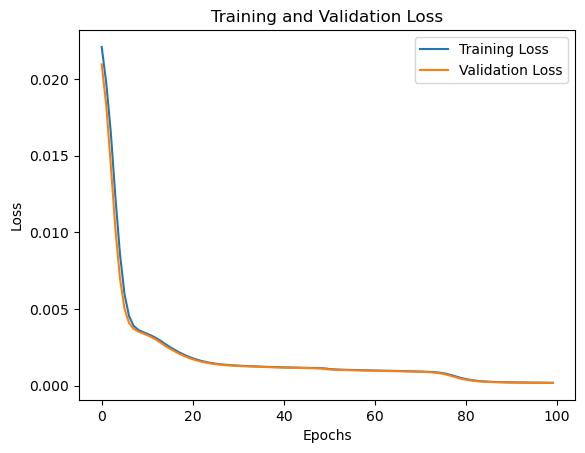

In [80]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

4. In order to obtain the scores for the training data pass it through the autoencoder and get the reconstruction error for each sample. Compute
a threshold that will be used to classify data with the numpy.quantile function and the contamination rate of the dataset. Compute the balanced accuracy for both the training and testing set

In [82]:
reconstructed_train = model.predict(X_train)
reconstruction_error_train = np.mean(np.square(X_train - reconstructed_train), axis=1)

reconstructed_test = model.predict(X_test)
reconstruction_error_test = np.mean(np.square(X_test - reconstructed_test), axis=1)

contamination_rate = np.mean(X_train)
threshold = np.quantile(reconstruction_error_train, 1 - contamination_rate)

train_predictions = reconstruction_error_train > threshold
test_predictions = reconstruction_error_test > threshold

train_balanced_accuracy = balanced_accuracy_score(y_train, train_predictions)
test_balanced_accuracy = balanced_accuracy_score(y_test, test_predictions)

print(f'Training Balanced Accuracy: {train_balanced_accuracy}')
print(f'Testing Balanced Accuracy: {test_balanced_accuracy}')

768/768 ━━━━━━━━━━━━━━━━━━━━ 1s 878us/step
768/768 ━━━━━━━━━━━━━━━━━━━━ 1s 759us/step
Training Balanced Accuracy: 0.7723977328908695
Testing Balanced Accuracy: 0.7706803197769785


Ex. 4
1. In this exercise we will use the mnist dataset from tensorflow.keras.datasets.mnist. After you load the dataset with tensorflow.keras.datasets mnist.load data() you will normalize it by dividing with 255. In order to simulate anomalies, you will add some noise to the images with tensorflow.random.normal (multiplied by a factor of 0.35). You will use tensorflow.clip by value to keep the range of the pixels [0, 1].

In [92]:
import tensorflow as tf

(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

noise_factor = 0.35
X_train_noisy = X_train + noise_factor * tf.random.normal(shape=X_train.shape)
X_test_noisy = X_test + noise_factor * tf.random.normal(shape=X_test.shape)

X_train_noisy = tf.clip_by_value(X_train_noisy, 0.0, 1.0)
X_test_noisy = tf.clip_by_value(X_test_noisy, 0.0, 1.0)


2. Design a Convolutional Autoencoder class that uses the keras.Sequential
model to create encoder and decoder submodels that contain keras.layers.Conv2D
and keras.layers.Conv2DTranspose layers. The encoder will contain:
    • 1 Conv2D layer with 8 (3 X 3) filters, relu activation, strides=2 and padding - ’same’
    • 1 Conv2D layer with 4 (3 X 3) filters and the rest of params as above
The decoder will consist of:
    • 1 Conv2DTranspose layer with the same parameters as the last layer of the encoder
    • 1 Conv2DTranspose layer with the same parameters as the first layer of the encoder
    • 1 Conv2D layer with 1 filter with sigmoid activation that will reconstruct the original image

In [111]:
class ConvAutoencoder(keras.Model):
    def __init__(self):
        super().__init__()
        self.encoder = keras.Sequential([
            keras.layers.InputLayer(shape=(28, 28, 1)),
            keras.layers.Conv2D(filters=8, kernel_size=(3, 3), strides=2, padding='same', activation='relu'),
            keras.layers.Conv2D(filters=4, kernel_size=(3, 3), strides=2, padding='same', activation='relu')
        ])
        
        self.decoder = keras.Sequential([
            keras.layers.Conv2DTranspose(filters=4, kernel_size=(3, 3), strides=2, padding='same', activation='relu'),
            keras.layers.Conv2DTranspose(filters=8, kernel_size=(3, 3), strides=2, padding='same', activation='relu'),
            keras.layers.Conv2D(filters=1, kernel_size=(3, 3), padding='same', activation='sigmoid')
        ])

    def call(self, inputs):
        x = self.decoder(self.encoder(inputs))
        return x

model = ConvAutoencoder()

3. Compile your model using adam optimizer and mse loss and fit it with your training data using 10 epochs and a batch size of 64 (use the test data as validation data in the trainig process). Use only the original train data for training. Compute the reconstruction loss for the training data and a threshold (that will be the mean of the reconstruction errors + their standard deviation). Based on the threshold and the obtained reconstruction errors classify both the original test images and the ones that have the added noise (and compute the corresponding accuracy).

In [112]:
model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, X_train, batch_size=64, epochs=10, validation_data=(X_test, X_test))

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0846 - val_loss: 0.0113
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0087 - val_loss: 0.0054
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0052 - val_loss: 0.0043
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0043 - val_loss: 0.0039
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0040 - val_loss: 0.0038
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0038 - val_loss: 0.0032
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0031 - val_loss: 0.0027
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 9/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 10/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0025 - val_loss: 0.0024


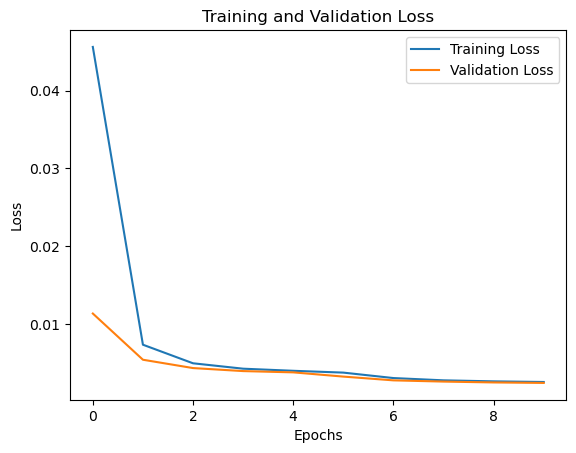

In [113]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [114]:
from sklearn.metrics import accuracy_score

reconstructed_train = model.predict(X_train)
reconstruction_error_train = np.mean(np.square(X_train - reconstructed_train), axis=(1, 2, 3))

reconstructed_test = model.predict(X_test)
reconstruction_error_test = np.mean(np.square(X_test - reconstructed_test), axis=(1, 2, 3))

reconstructed_test_noisy = model.predict(X_test_noisy)
reconstruction_error_test_noisy = np.mean(np.square(X_test - reconstructed_test_noisy), axis=(1, 2, 3))

threshold = np.mean(reconstruction_error_train) + np.std(reconstruction_error_test)

test_predictions = reconstruction_error_test > threshold
test_predictions_noisy = reconstruction_error_test_noisy > threshold

accuracy_original = accuracy_score(y_test, test_predictions)
accuracy_noisy = accuracy_score(y_test, test_predictions_noisy)

print(f'Accuracy on original test images: {accuracy_original}')
print(f'Accuracy on noisy test images: {accuracy_noisy}')


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Accuracy on original test images: 0.0902
Accuracy on noisy test images: 0.1135


4. Plot in the same figure, on four rows, 5 test images: on the first row - the original ones, on the second one - the images with the added noise, on the third, the reconstructed images obtained from the original ones and on the last row the reconstructed images obtained from the images with added noise.

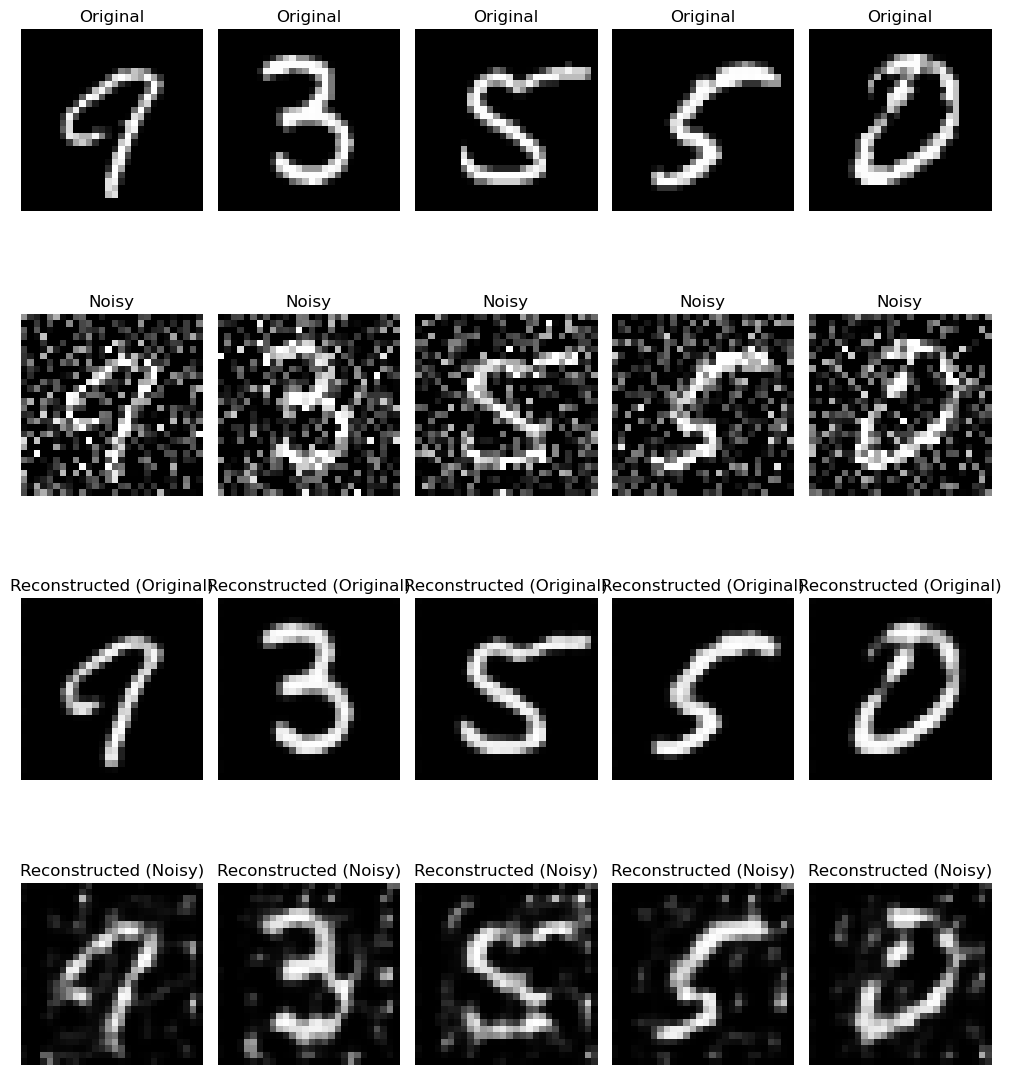

In [115]:
num_images = 5
random_indices = np.random.choice(X_test.shape[0], num_images, replace=False)

X_test = np.array(X_test)  
X_test_noisy = np.array(X_test_noisy) 
reconstructed_test = np.array(reconstructed_test)
reconstructed_test_noisy = np.array(reconstructed_test_noisy)


original_images = X_test[random_indices]
noisy_images = X_test_noisy[random_indices]
reconstructed_images_original = reconstructed_test[random_indices]
reconstructed_images_noisy = reconstructed_test_noisy[random_indices]

fig, axs = plt.subplots(4, num_images, figsize=(10, 12))

for i in range(num_images):
    axs[0, i].imshow(original_images[i].reshape(28, 28), cmap='gray')
    axs[0, i].axis('off')
    axs[0, i].set_title("Original")

for i in range(num_images):
    axs[1, i].imshow(noisy_images[i].reshape(28, 28), cmap='gray')
    axs[1, i].axis('off')
    axs[1, i].set_title("Noisy")

for i in range(num_images):
    axs[2, i].imshow(reconstructed_images_original[i].reshape(28, 28), cmap='gray')
    axs[2, i].axis('off')
    axs[2, i].set_title("Reconstructed (Original)")

for i in range(num_images):
    axs[3, i].imshow(reconstructed_images_noisy[i].reshape(28, 28), cmap='gray')
    axs[3, i].axis('off')
    axs[3, i].set_title("Reconstructed (Noisy)")

plt.tight_layout()
plt.show()

5. Modify the training stage in order to obtain a Denoising Autoencoder and print the same figure again.

In [118]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

noise_factor = 0.35
X_train_noisy = X_train + noise_factor * tf.random.normal(shape=X_train.shape)
X_test_noisy = X_test + noise_factor * tf.random.normal(shape=X_test.shape)

X_train_noisy = tf.clip_by_value(X_train_noisy, 0.0, 1.0)
X_test_noisy = tf.clip_by_value(X_test_noisy, 0.0, 1.0)

In [119]:
model_denoise = ConvAutoencoder()
model_denoise.compile(optimizer='adam', loss='mse')
history_denoise = model_denoise.fit(X_train_noisy, X_train, epochs=10, batch_size=64, validation_data=(X_test_noisy, X_test))
test_images_denoised = model_denoise.predict(X_test_noisy)

test_images_denoised = np.array(test_images_denoised)

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0988 - val_loss: 0.0130
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0129 - val_loss: 0.0119
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0120 - val_loss: 0.0115
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0117 - val_loss: 0.0111
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0112 - val_loss: 0.0096
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0097 - val_loss: 0.0091
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0093 - val_loss: 0.0090
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0092 - val_loss: 0.0090
Epoch 9/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0091 - val_loss: 0.0089
Epoch 10/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0091 - val_loss: 0.0088
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


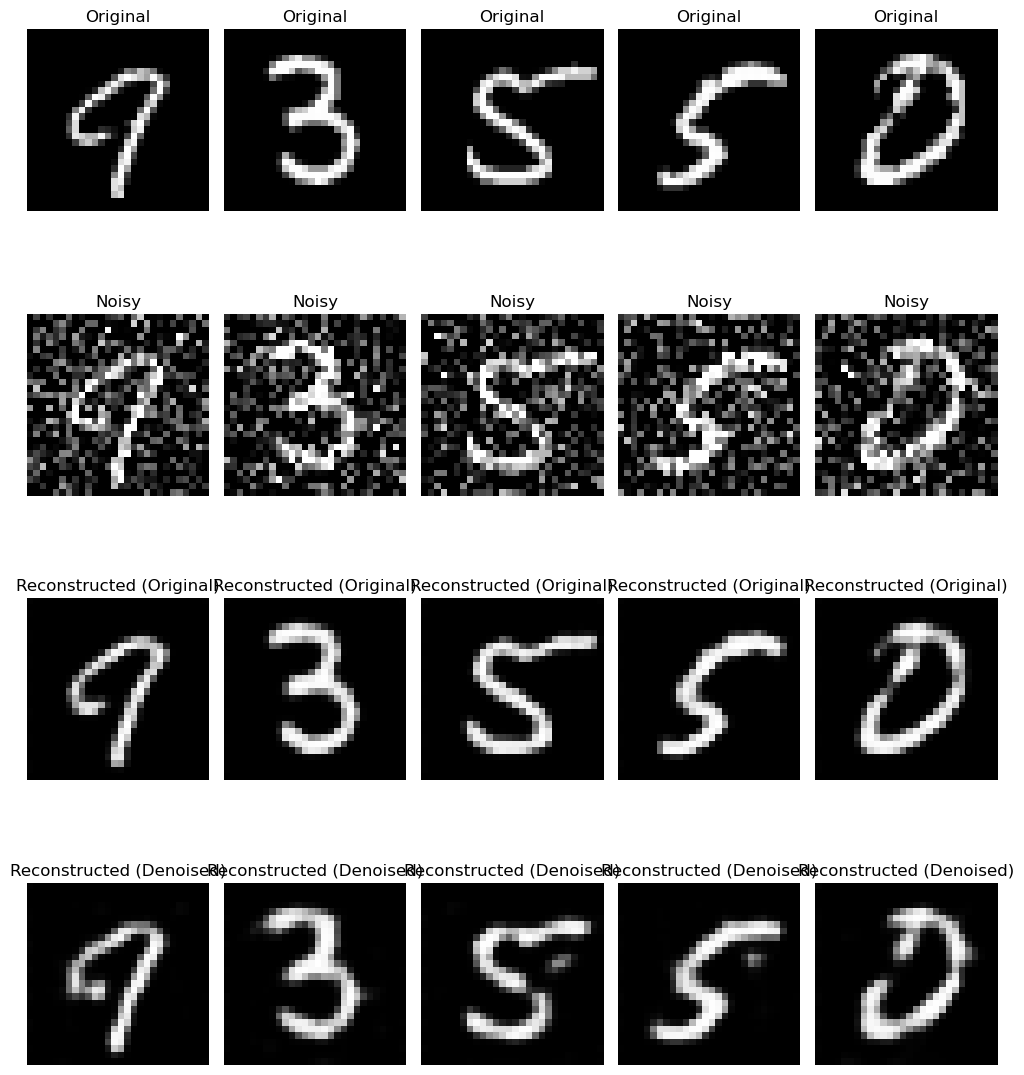

In [ ]:
X_test = np.array(X_test)  
X_test_noisy = np.array(X_test_noisy) 
reconstructed_test = np.array(reconstructed_test)
reconstructed_test_noisy = np.array(reconstructed_test_noisy)

original_images = X_test[random_indices]
noisy_images = X_test_noisy[random_indices]
reconstructed_images_original = reconstructed_test[random_indices]
reconstructed_images_noisy = reconstructed_test_noisy[random_indices]

original_images = X_test[random_indices]
noisy_images = X_test_noisy[random_indices]
reconstructed_images_original = reconstructed_test[random_indices]
test_images_denoised = test_images_denoised[random_indices]

fig, axs = plt.subplots(4, num_images, figsize=(10, 12))

for i in range(num_images):
    axs[0, i].imshow(original_images[i].reshape(28, 28), cmap='gray')
    axs[0, i].axis('off')
    axs[0, i].set_title("Original")

for i in range(num_images):
    axs[1, i].imshow(noisy_images[i].reshape(28, 28), cmap='gray')
    axs[1, i].axis('off')
    axs[1, i].set_title("Noisy")

for i in range(num_images):
    axs[2, i].imshow(reconstructed_images_original[i].reshape(28, 28), cmap='gray')
    axs[2, i].axis('off')
    axs[2, i].set_title("Reconstructed (Original)")

for i in range(num_images):
    axs[3, i].imshow(test_images_denoised[i].reshape(28, 28), cmap='gray')
    axs[3, i].axis('off')
    axs[3, i].set_title("Reconstructed (Denoised)")

plt.tight_layout()
plt.show()